In [ ]:
## Palantir Pseudotime and Magic Imputation of Genes

In [1]:
import scanpy as sc
from scipy import io
from scipy.sparse import coo_matrix, csr_matrix
import numpy as np
import os
import pandas as pd
import scvelo as scv
#import cellrank as cr investigate the compatibility with M1 chip

In [2]:
import psutil

# Get the available system memory in bytes
ram_gb = psutil.virtual_memory().total / 1e9
print(f"Available RAM: {ram_gb:.2f} GB")
# Get the available system memory in bytes
available_memory = psutil.virtual_memory().available / 1e9
# Convert to GB
available_memory_gb = available_memory / (1024 ** 3)
print(f"Available memory: {available_memory_gb:.2f} GB")

Available RAM: 811.11 GB
Available memory: 0.00 GB


In [3]:
!pwd

/groups/mb928_gp/mp4486/palantir


In [4]:
# Read in RNA object
adata = sc.read('../scgpt/data/rna_leidein.h5ad')
adata

AnnData object with n_obs × n_vars = 495037 × 36601
    obs: 'orig.ident', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_RNA', 'nFeature_RNA', 'mitoPercent', 'gex_barcode', 'gex_raw_reads', 'atac_barcode', 'atac_raw_reads', 'atac_unmapped_reads', 'atac_mitochondrial_reads', 'atac_fragments', 'atac_TSS_fragments', 'atac_peak_region_fragments', 'atac_peak_region_cutsites', 'scDblFinder.class', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.cxds_score', 'RNA_snn_res.0.8', 'seurat_clusters', 'sample', 'orig_sample_cluster', 'seurat_clusters_12162024', 'scDblFinder.score_12162024', 'RNA_snn_res.1.6', 'ident', 'batch', 'ID4', 'Brain_bank', 'seq_study_ID', 'Sex', 'Age', 'PMI', 'Diagnosis', 'Suicide', 'RIN', 'sample_barcode', 'harmony_rna_clusters_0.5', 'seurat_rna_clusters_0.5', 'harmony_rna_clusters_0.25', 'n_cells', 'predictions', 'cell_group', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'pct_reads_in_peaks', 'blacklist_fraction', 'atac_clusters_0.

In [5]:
# Read in most updated metadata and add it to adata object
meta = pd.read_csv('../Multiome_process/meta/current_working_multiome_meta (1).csv', index_col=0)
adata.obs = meta

In [7]:
# Read in Harmony and UMAP embeddings
umap_srat = pd.read_csv("imgns_sub_umap_10.08.25.csv", index_col=0)
harmony_srat = pd.read_csv("imgns_sub_harmony_rna_10.08.25.csv", index_col=0)

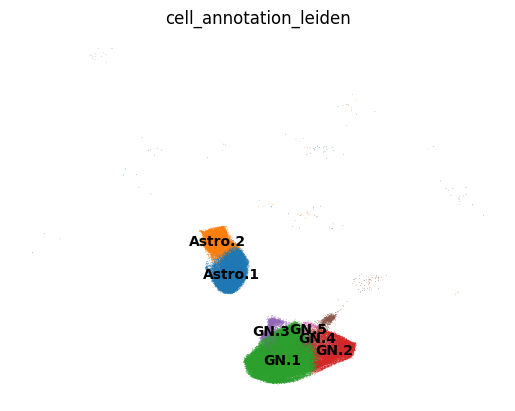

In [8]:
# Subset adata based on just the barcodes in the embeddings
to_subset = list(harmony_srat.index)
adata_subset = adata[adata.obs['sample_barcode'].isin(to_subset)]
sc.pl.embedding(adata_subset, basis='X_wnn.umap', color=['cell_annotation_leiden'], frameon=False, legend_loc= 'on data')

In [9]:
# Add embeddings to the adata objects

# umap
adata_subset.obsm["X_umap_seurat"] = umap_srat.to_numpy()

# harmony
adata_subset.obsm["X_harmony_seurat"] = harmony_srat.to_numpy()


# Palantir

In [10]:
import palantir

In [14]:
dm_res = palantir.utils.run_diffusion_maps(adata_subset, n_components=10,pca_key='X_harmony_seurat')
ms_data = palantir.utils.determine_multiscale_space(adata_subset)


In [17]:
sc.pp.neighbors(adata_subset, use_rep='X_harmony_seurat')
sc.tl.umap(adata_subset, min_dist=0.4, spread=3)

In [18]:
sc.tl.leiden(adata_subset)

In [19]:
adata_subset.obs['batch'] = adata_subset.obs['batch'].astype('category')


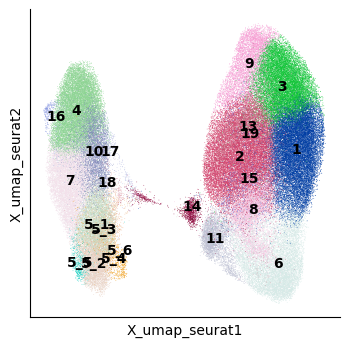

In [20]:
sc.pl.embedding(adata_subset, basis='X_umap_seurat',color=['astro_gc_wnn'], frameon=True, title=['', ''], legend_loc='on data')

In [21]:
palantir.utils.run_magic_imputation?

Signature:
palantir.utils.run_magic_imputation(
    data: Union[numpy.ndarray, pandas.core.frame.DataFrame, anndata._core.anndata.AnnData, scipy.sparse._csr.csr_matrix],
    dm_res: Optional[dict] = None,
    n_steps: int = 3,
    sim_key: str = 'DM_Similarity',
    expression_key: str = None,
    imputation_key: str = 'MAGIC_imputed_data',
    n_jobs: int = -1,
    sparse: bool = True,
    clip_threshold: float = 0.01,
) -> Union[pandas.core.frame.DataFrame, NoneType, scipy.sparse._csr.csr_matrix, numpy.ndarray]
Docstring:
Run MAGIC imputation on the data.

Parameters
----------
data : Union[np.ndarray, pd.DataFrame, AnnData, csr_matrix]
    Array or DataFrame of cells X genes, AnnData object, or a sparse csr_matrix.
dm_res : Union[dict, None], optional
    Diffusion map results from run_diffusion_maps.
    If None and data is a AnnData object, its obsp[kernel_key] is used. Default is None.
n_steps : int, optional
    Number of steps in the diffusion operator. Default is 3.
expression

In [22]:
# Run magic imputation on Selected Genes

import palantir
genes_of_interest = ['SOX2', 'PAX6', 'NES', 'ASCL1','S100B','GFAP', 'ETNPPL', 'HES5','AQP4', 'VIM',
                 'FABP7', 'NOTCH1','NOTCH2', 'MKI67', 'MCM2', 'PCNA',  'FOXO3', 'NEUROG2', 'OLIG1', 'OLIG2',
                 'NEUROD1', 'TOP2A', 'EOMES', 'NR2E1', 'MYT1L', 'CALB1', 'CALB2',
                 'RELN','ST8SIA2','ST8SIA4','DCX', 'STMN2', 'TUBB3', 'PROX1', 'FST', 'BHLHE22', 'POSTN',
                 'RBFOX3', 'SYT1', 'MBP', 'SOX11', 'SOX4','GAD1', 'GAD2', 'SHH', 'PTCH1', 'SMO', 'GLI1', 'GLI2',
                  'BMP2', 'BMP4', 'BMP7','BMPR1A','BMPR1B', 'BMPR2','COL25A1',
               'CTNNB1', 'SEMA3D', 'FOS','HSPB8',
                    'RSPO2', 'ANGPT1', 'KIT', 'CPAMD8', 'PRKX','SMOC1','ID3', 'NMB', 'APLNR','ADIRF', 'TNC', 'JUNB', 'IGFBP5', 'BAMBI',
                    'GJA1', 'PRTG','B2M','HES1', 'S100A10', 'MARCKS', 'YAP1', 'HES6', 'ERBB4', 'BHLHE40', 'EGFR', 'FGF1', 'FGF2', 'HEY2', 'WNT3',
                    'DOCK7','SEMA6C', 'NELL1',
                    'CREB3L1', 'MDGA2', 'CX3CR1', 'CSF1R', 'INPP5D', 'PTPRC', 'RUNX1', 'SLC1A3',
                    'LRP2', 'CHRM3', 'FGF12', 'NETO2', 'FGF14', 'GRIN2A', 'KLHL1', 'TGFB1', 'SMAD7', 'OTOF', 'SLC1A6', 'TRPC6',
                    'FGFR1','EGR3','DPYSL5', 'TRIM54','MAOB','KCTD4','HEY1','CHRD','LAMA2','BDNF','RASSF9', 'TGFB1','SMAD3','MEIS1','DLX1',
                     'DLX2','NR2E1','TP53','GLI3','RMST','CHI3L1',
                     'OSMR','HAP1','MACF1', 'OAF', 'F3','LMX1A','OTX2','ESM1','STMN1','GLRA2','EPHA3','KCNH7','APOLD1','CENPF',
                    'SMC4', 'HMGB3','HMGB2','CNTNAP2','FEZF2','ELMO1','MTSS1','NNAT','NEUROD6', 'RRM2', 'EZH2','SYNE2','DRAXIN', 'RBP1','TUBA1A', 'FABP5',
                    'SBK1','SMIM18','PAFAH1B3', 'FXYD7', 'TMSB4X','SNCG','TBR1','INSM1','LAMP5','EMX1','EMX2','ASCL2','ASCL3']



gene_sub = adata_subset[:, genes_of_interest].copy()
imputed_X = palantir.utils.run_magic_imputation(gene_sub)


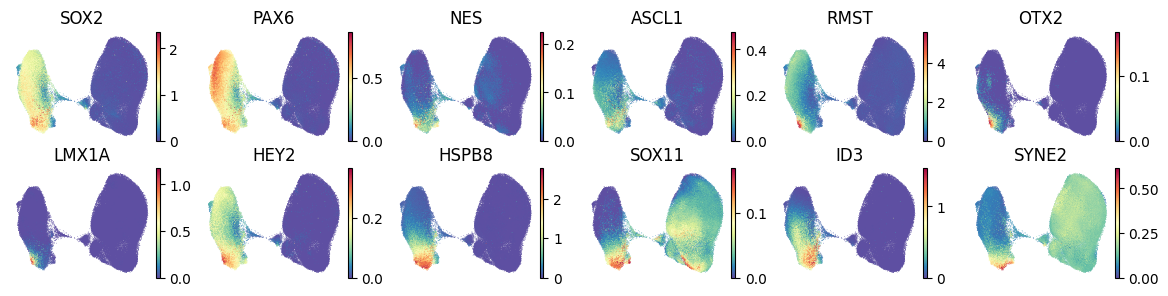

In [223]:
# NSCs
import matplotlib.pyplot as plt

fig = sc.pl.embedding(
    gene_sub,
    basis="X_umap_seurat",
    layer="MAGIC_imputed_data",
    color=['SOX2','PAX6', 'NES', 'ASCL1', 'RMST',
          'OTX2','LMX1A','HEY2','HSPB8','SOX11','ID3','SYNE2',
                    ],
    frameon=False,
    ncols =6,
    return_fig=True
)
fig.set_size_inches(14, 3)  # Adjust width and height as needed
fig.savefig("QNPmagic_imputation_genes_on_UMAP.pdf", format="pdf", bbox_inches="tight")


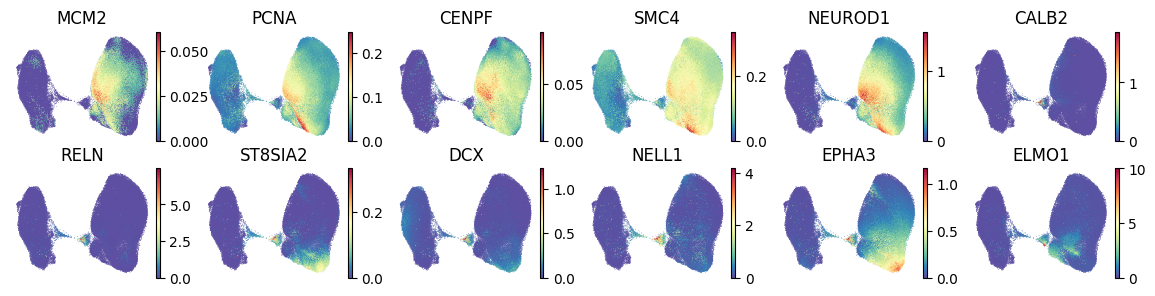

In [216]:
# Proliferating and INPs
import matplotlib.pyplot as plt

fig = sc.pl.embedding(
    gene_sub,
    basis="X_umap_seurat",
    layer="MAGIC_imputed_data",
    color=['MCM2','PCNA','CENPF','SMC4','NEUROD1','CALB2',
           'RELN','ST8SIA2','DCX','NELL1','EPHA3','ELMO1'
                    ],
    frameon=False,
    ncols =6,
    return_fig=True
)
fig.set_size_inches(14, 3)  # Adjust width and height as needed
fig.savefig("INPmagic_imputation_genes_on_UMAP.pdf", format="pdf", bbox_inches="tight")


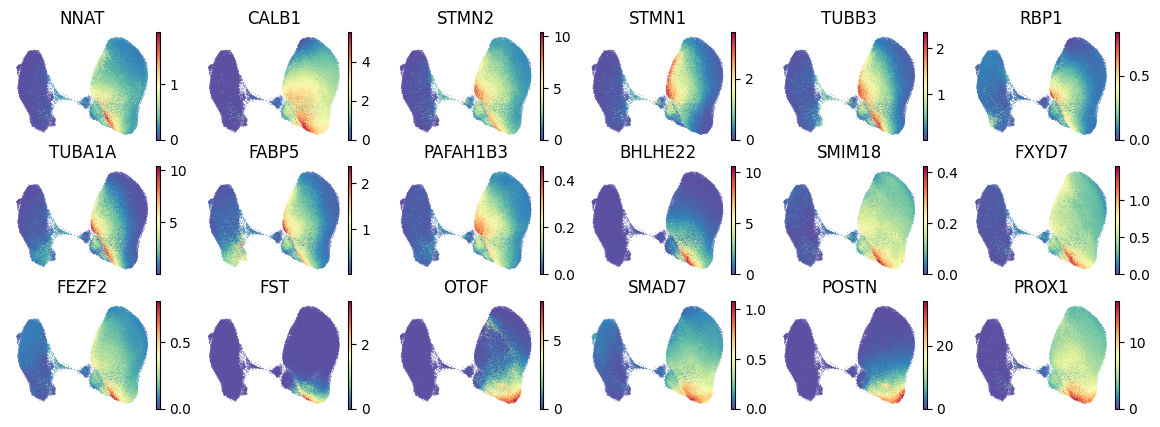

In [240]:
# IMGNS
import matplotlib.pyplot as plt

fig = sc.pl.embedding(
    gene_sub,
    basis="X_umap_seurat",
    layer="MAGIC_imputed_data",
    color=[
        'NNAT','CALB1','STMN2','STMN1', 'TUBB3','RBP1', 'TUBA1A', 'FABP5','PAFAH1B3', 'BHLHE22','SMIM18','FXYD7','FEZF2','FST',
        'OTOF','SMAD7','POSTN','PROX1'
    ],
    frameon=False,
    ncols =6,
    return_fig=True
)
fig.set_size_inches(14, 4.5)  # Adjust width and height as needed
fig.savefig("IMGNmagic_imputation_genes_on_UMAP.pdf", format="pdf", bbox_inches="tight")


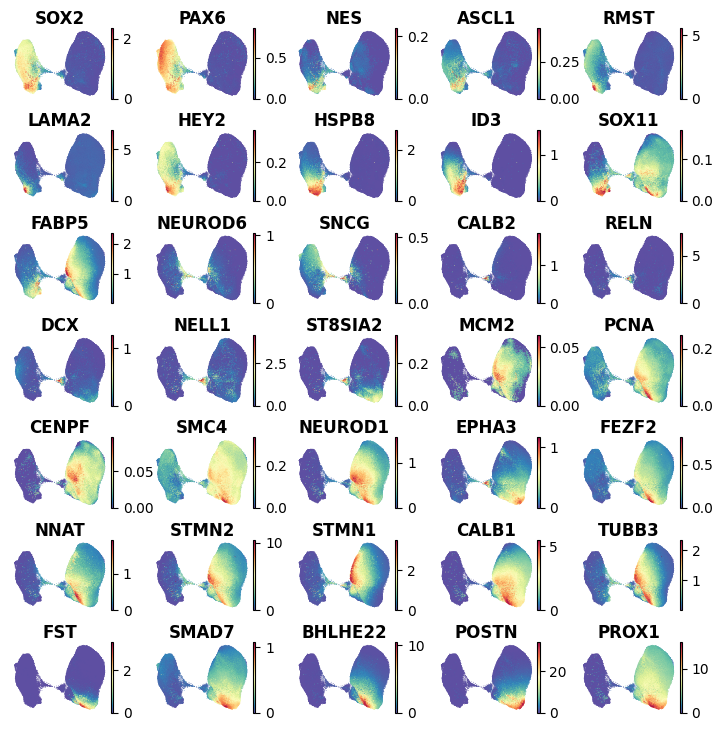

In [23]:
import matplotlib.pyplot as plt

fig = sc.pl.embedding(
    gene_sub,
    basis="X_umap_seurat",
    layer="MAGIC_imputed_data",
    color=['SOX2','PAX6', 'NES', 'ASCL1','RMST','LAMA2','HEY2','HSPB8','ID3','SOX11','FABP5','NEUROD6','SNCG','CALB2',
                 'RELN','DCX','NELL1','ST8SIA2',
                 'MCM2', 'PCNA','CENPF','SMC4','NEUROD1',
                 'EPHA3','FEZF2','NNAT',
           'STMN2','STMN1','CALB1','TUBB3', 'FST','SMAD7','BHLHE22', 'POSTN','PROX1',
                    ],
    frameon=False,
    ncols =5,
    return_fig=True,
    hspace = .45,
    wspace = .3,
    legend_fontweight='bold'
)
fig.set_size_inches(8.5, 8)  # Adjust width and height as needed
for ax in fig.axes:
    t = ax.get_title()
    ax.set_title(t, pad=1, fontweight='bold')   # Re-set the same title with smaller padding
#fig.subplots_adjust(hspace=0.2, wspace=0.2)

fig.savefig("heatmaps_magic_imputation_genes_on_UMAP_10.29.25.pdf", format="pdf", bbox_inches="tight")


(<Figure size 1500x600 with 10 Axes>,
 {0: <Axes: title={'center': 'Component 0'}>,
  1: <Axes: title={'center': 'Component 1'}>,
  2: <Axes: title={'center': 'Component 2'}>,
  3: <Axes: title={'center': 'Component 3'}>,
  4: <Axes: title={'center': 'Component 4'}>,
  5: <Axes: title={'center': 'Component 5'}>,
  6: <Axes: title={'center': 'Component 6'}>,
  7: <Axes: title={'center': 'Component 7'}>,
  8: <Axes: title={'center': 'Component 8'}>,
  9: <Axes: title={'center': 'Component 9'}>})

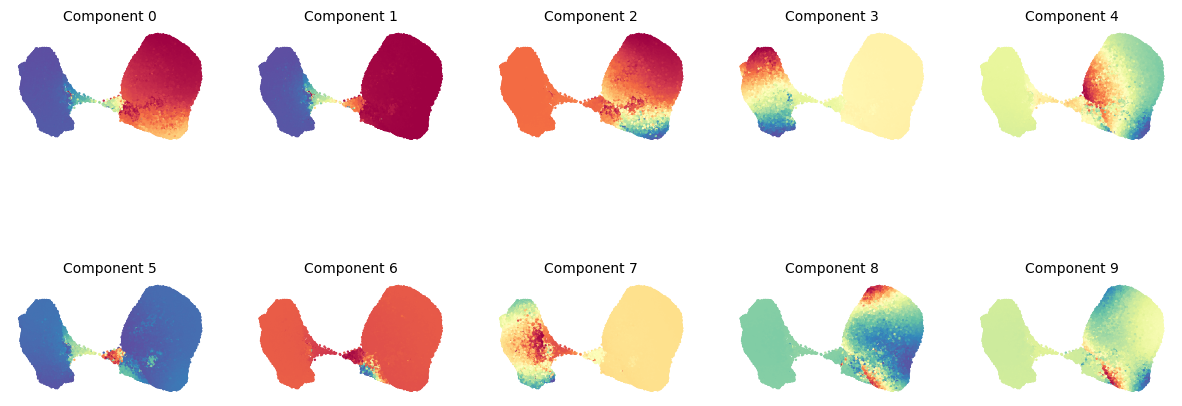

In [204]:
# Plot diffusion components
palantir.plot.plot_diffusion_components(adata_subset, embedding_basis='X_umap_seurat')


In [108]:
# Select 50 random cells from starting cluster
early_states = gene_sub.obs_names[gene_sub.obs['astro_gc_wnn']=='4_5'].to_list()
subset_50 = np.random.choice(terminal_states, size=60, replace=False)
subset_50

array(['CM058_TATAGCTCATTGTGTG-1', 'MM081_AACGCCCAGTGTTGTA-1',
       'CM041_TCAGCAAGTAACCACA-1', 'CM058_CCTTAACGTTGAAGCC-1',
       'CM058_AGTAAGTAGGTTAGAG-1', 'CM057_TGGACGGAGTGAACCT-1',
       'CM115_GTAAGCGCAGTTAGCC-1', 'CM057_CATCCCAGTTTGTTGC-1',
       'CM042_ACCTGTTGTCTTGCAT-1', 'CM025_ATGACAACAGCTCATA-1',
       'MM145_CCTGAGTCAAGGTGGC-1', 'CM114_ACTTACTTCATGCAAC-1',
       'MM150_CCCGCAACACAATACT-1', 'CM089_GGAGGTTAGACAGGTA-1',
       'MM145_CTACAACAGTATTGGC-1', 'CM071_GCAGGCAAGGCTGGCT-1',
       'CM057_GAGAACCAGTTATTCC-1', 'CM042_TGGCGGTTCCCATAGG-1',
       'CM058_CCCTCAGTCCTGAGTG-1', 'CM057_TGATGAACAGTTAAAG-1',
       'CM058_TCCTGGTTCCTCCATA-1', 'MM006_ATATGCATCGGCCATA-1',
       'CM113_GTTTCTAGTCTATCGT-1', 'CM057_CATAGGCGTGTTGTAG-1',
       'CM069_AATTTCCTCTAGCGAT-1', 'MM101_GATGGCTGTCCTAAGA-1',
       'CM113_CACCAACCACAAACTT-1', 'CM038_TCTAGCCTCGGGCCAT-1',
       'CM057_ACCACATAGGCTTAGT-1', 'CM057_TGTAAAGCAGGCCAAA-1',
       'CM028_GATTCCTGTTAGACCA-1', 'CM058_CCGCACACAATAA

In [ ]:
import scipy
start_genes = ["SOX2", 'PAX6', 'NES', 'ASCL1']
expr = gene_sub[:, start_genes].X
if scipy.sparse.issparse(expr):
    expr = expr.toarray()
expressing_cells = (expr[:, 0] > 1) & (expr[:, 1] > 1)& (expr[:, 2] > 0.5) & (expr[:, 3] > 0.5)   
adata_expr = adata_subset[expressing_cells]
plot = adata_expr.obs['astro_gc_wnn']
plot

In [ ]:
# Look at cells with ImGC markers

import scipy
start_genes = ["BHLHE22", 'POSTN', 'FST', 'OTOF']
expr = adata_subset[:, start_genes].X
if scipy.sparse.issparse(expr):
    expr = expr.toarray()
expressing_cells = (expr[:, 0] > 2) & (expr[:, 1] > 2)& (expr[:, 2] > 2) & (expr[:, 3] > 2)   
adata_expr = adata_subset[expressing_cells]
plot = adata_expr.obs['astro_gc_wnn']
plot

In [ ]:
import scipy
start_genes = ['RELN','DCX','GAD2']
expr = gene_sub[:, start_genes].X
if scipy.sparse.issparse(expr):
    expr = expr.toarray()
expressing_cells = (expr[:, 0] > 0) & (expr[:, 1] >0) & (expr[:, 2] <1) 
adata_expr = gene_sub[expressing_cells]
plot= adata_expr.obs['astro_gc_wnn']
plot

In [ ]:
import scipy
start_genes = ['SLC39A14','SOX2','PAX6','NES']
expr = adata_subset[:, start_genes].X
if scipy.sparse.issparse(expr):
    expr = expr.toarray()
expressing_cells = (expr[:, 0] > 0) & (expr[:, 1] >0) & (expr[:, 2] > 0)& (expr[:, 3] > 0)
adata_expr = adata_subset[expressing_cells]
plot= adata_expr.obs['astro_gc_wnn']
plot

In [116]:
# Select cells from terminal cluster
terminal_states = gene_sub.obs_names[gene_sub.obs['astro_gc_wnn']=='6'].to_list()
subset_50 = np.random.choice(terminal_states, size=60, replace=False)
subset_50

array(['CM116_AAAGGTTAGCTCCCTG-1', 'CM055_TCAAGAACACAGACTC-1',
       'CM115_TAGTGAGAGCTTAGTA-1', 'CM115_GCAGGTTGTAACCACA-1',
       'CM060_TTGGTGAGTCCGCTGT-1', 'CM024_GAGTGATCAATAGCCC-1',
       'CM115_CGGTAACGTCACAAAT-1', 'CM028_CCTCCTGAGGTTAGAG-1',
       'CM044_ACCCTCCCATGTTTGG-1', 'CM026_TTTACGAAGAAGCTAG-1',
       'CM115_CTGTTAAAGCAAGACA-1', 'CM056_TAATGGACATTGCAGC-1',
       'CM026_CCCATAACAAACGGGC-1', 'CM115_CTATGACAGAAAGCAT-1',
       'CM055_ATGTCAATCACAGACT-1', 'CM070_CTTCACTCAATATACC-1',
       'CM060_TGCAGGCTCCTAATTC-1', 'CM116_CACAGGCTCAATCTAG-1',
       'CM060_ACGAATCTCTTTAGGA-1', 'CM074_TAATTGCCAATATAGG-1',
       'CM091_CCGCTTAGTTCCGCAC-1', 'CM056_GGCTAGACAAGTGAAC-1',
       'CM073_ACACCTTGTGCTCCAC-1', 'CM073_CCGTTTGGTTAGCATG-1',
       'CM055_GCTGGATGTTGGTTAG-1', 'CM111_CGCTTCTAGGCGTAAA-1',
       'CM115_ACGACAAAGAGAGGAG-1', 'CM090_TCAGGTCCATAGTCAT-1',
       'CM115_GATGGCTGTTGGATAT-1', 'CM075_GTACGTAGTTGCACGG-1',
       'CM059_ACGCCACAGGCGCATC-1', 'CM074_GCCAATTAGTGGC

(<Figure size 600x600 with 1 Axes>, <Axes: >)

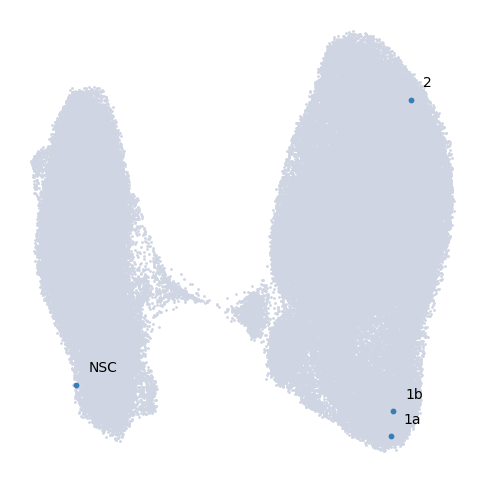

In [117]:
palantir.plot.highlight_cells_on_umap(gene_sub, pd.Series(['NSC','1a','1b','2'],['MM001_CACCAACCAAGACTCC-1','CM074_GCCAATTAGTGGCGGA-1','MM103_AGCTAACTCCTTAAGA-1','MM152_GGATACTTCCTTAGTT-1']), embedding_basis='X_umap_seurat')

In [140]:
palantir.core.run_palantir?

Signature:
palantir.core.run_palantir(
    data: Union[pandas.core.frame.DataFrame, anndata._core.anndata.AnnData],
    early_cell,
    terminal_states: Union[List, Dict, pandas.core.series.Series, NoneType] = None,
    knn: int = 30,
    num_waypoints: int = 1200,
    n_jobs: int = -1,
    scale_components: bool = True,
    use_early_cell_as_start: bool = False,
    max_iterations: int = 25,
    eigvec_key: str = 'DM_EigenVectors_multiscaled',
    pseudo_time_key: str = 'palantir_pseudotime',
    entropy_key: str = 'palantir_entropy',
    fate_prob_key: str = 'palantir_fate_probabilities',
    save_as_df: bool = None,
    waypoints_key: str = 'palantir_waypoints',
    seed: int = 20,
) -> Optional[object]
Docstring:
Executes the Palantir algorithm to derive pseudotemporal ordering of cells, their fate probabilities, and
state entropy based on the multiscale diffusion map results.

Parameters
----------
data : Union[pd.DataFrame, AnnData]
    Either a DataFrame of multiscale space diff

In [24]:
early_cell='MM001_CACCAACCAAGACTCC-1'
pr_res = palantir.core.run_palantir(
    gene_sub, early_cell, use_early_cell_as_start=True, seed=10)
)

Sampling and flocking waypoints...
Time for determining waypoints: 0.3248377561569214 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 2.078959310054779 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9998
Correlation at iteration 2: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


In [ ]:
palantir.plot.plot_palantir_results(gene_sub, s=3, embedding_basis='X_umap_seurat')


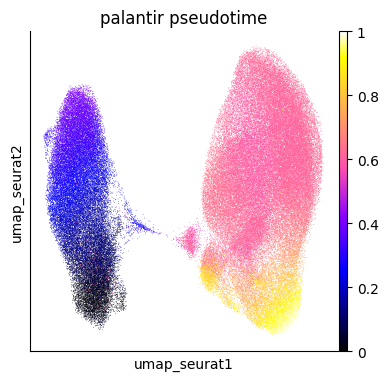

In [214]:
sc.pl.scatter(
    gene_sub,
    basis="umap_seurat",
    color=["palantir_pseudotime"],
    color_map="gnuplot2",
)

In [ ]:
masks = palantir.presults.select_branch_cells(gene_sub, eps=0.0000000000008)


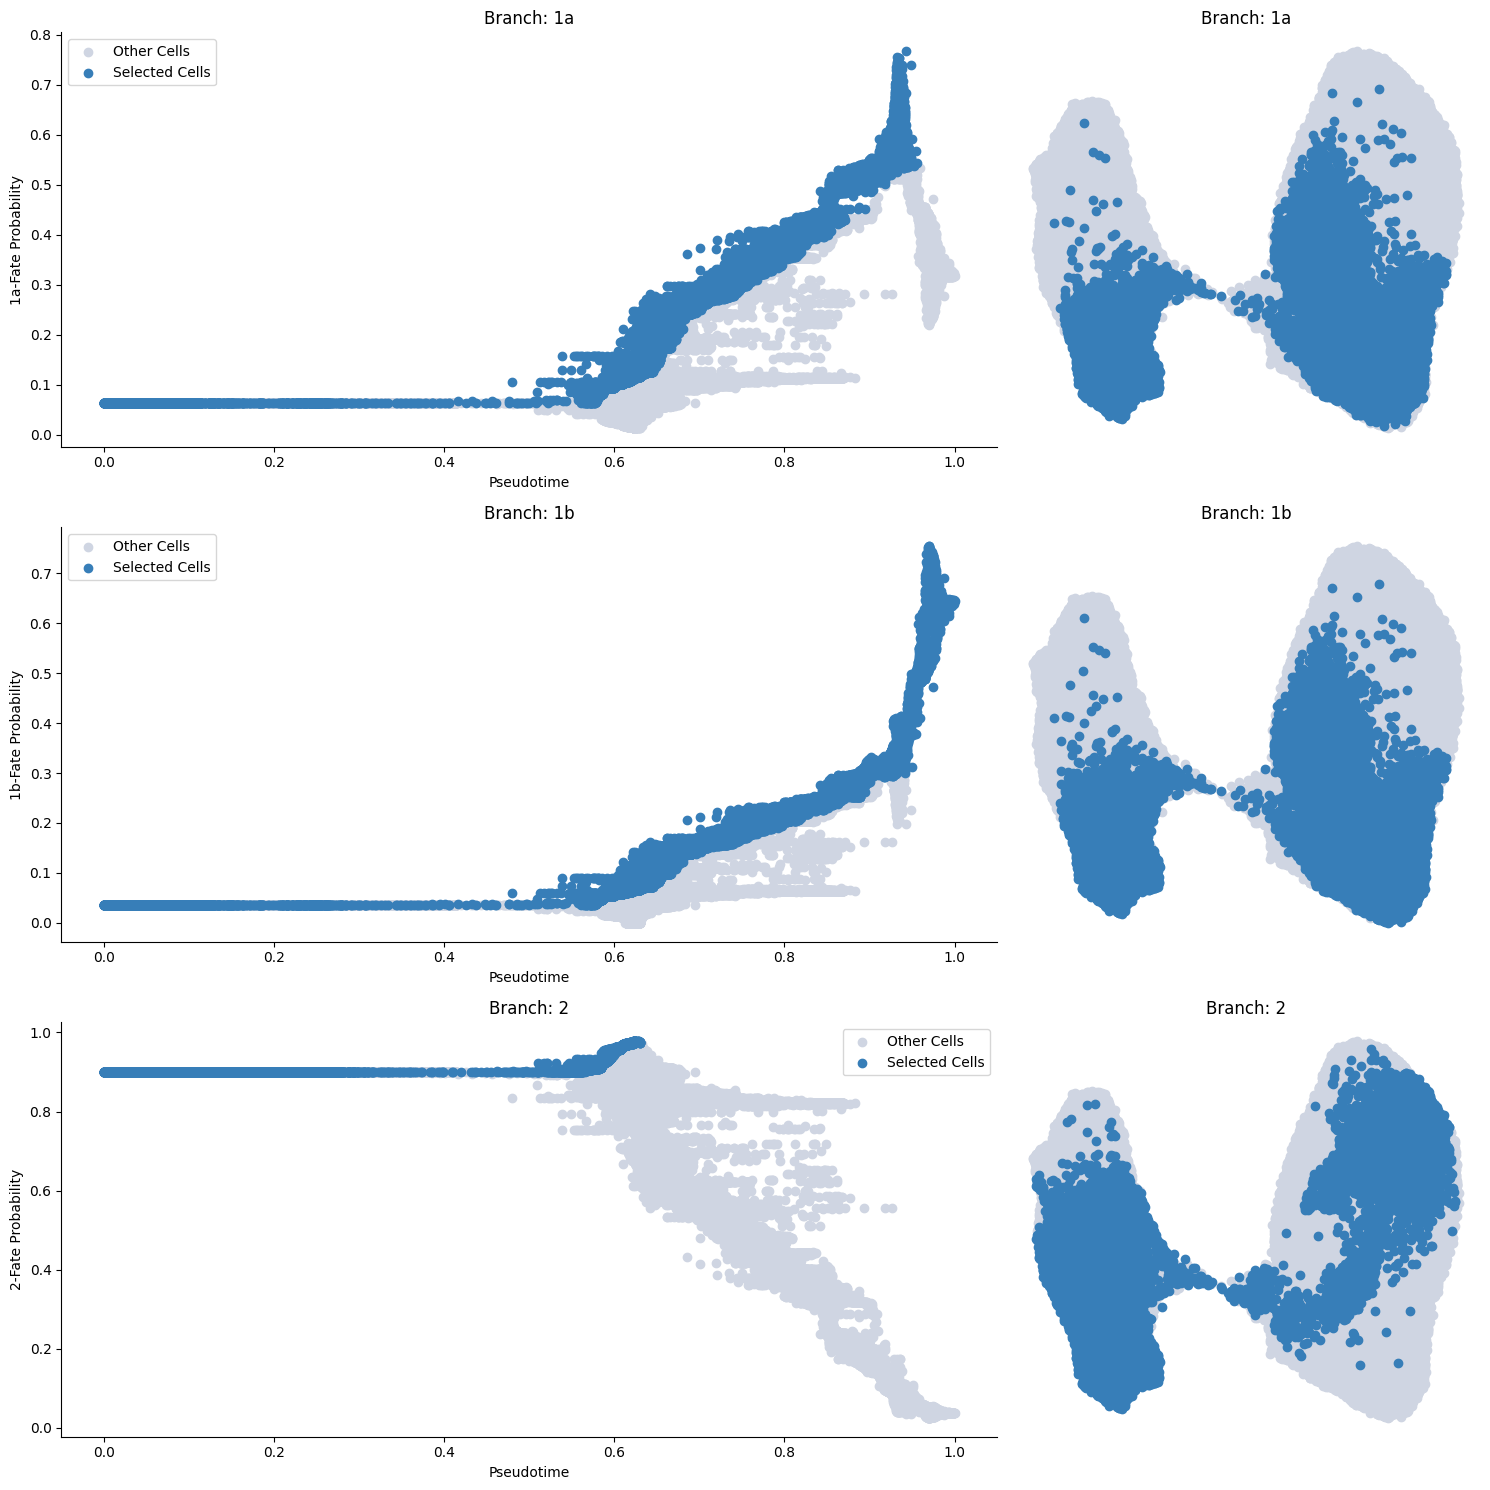

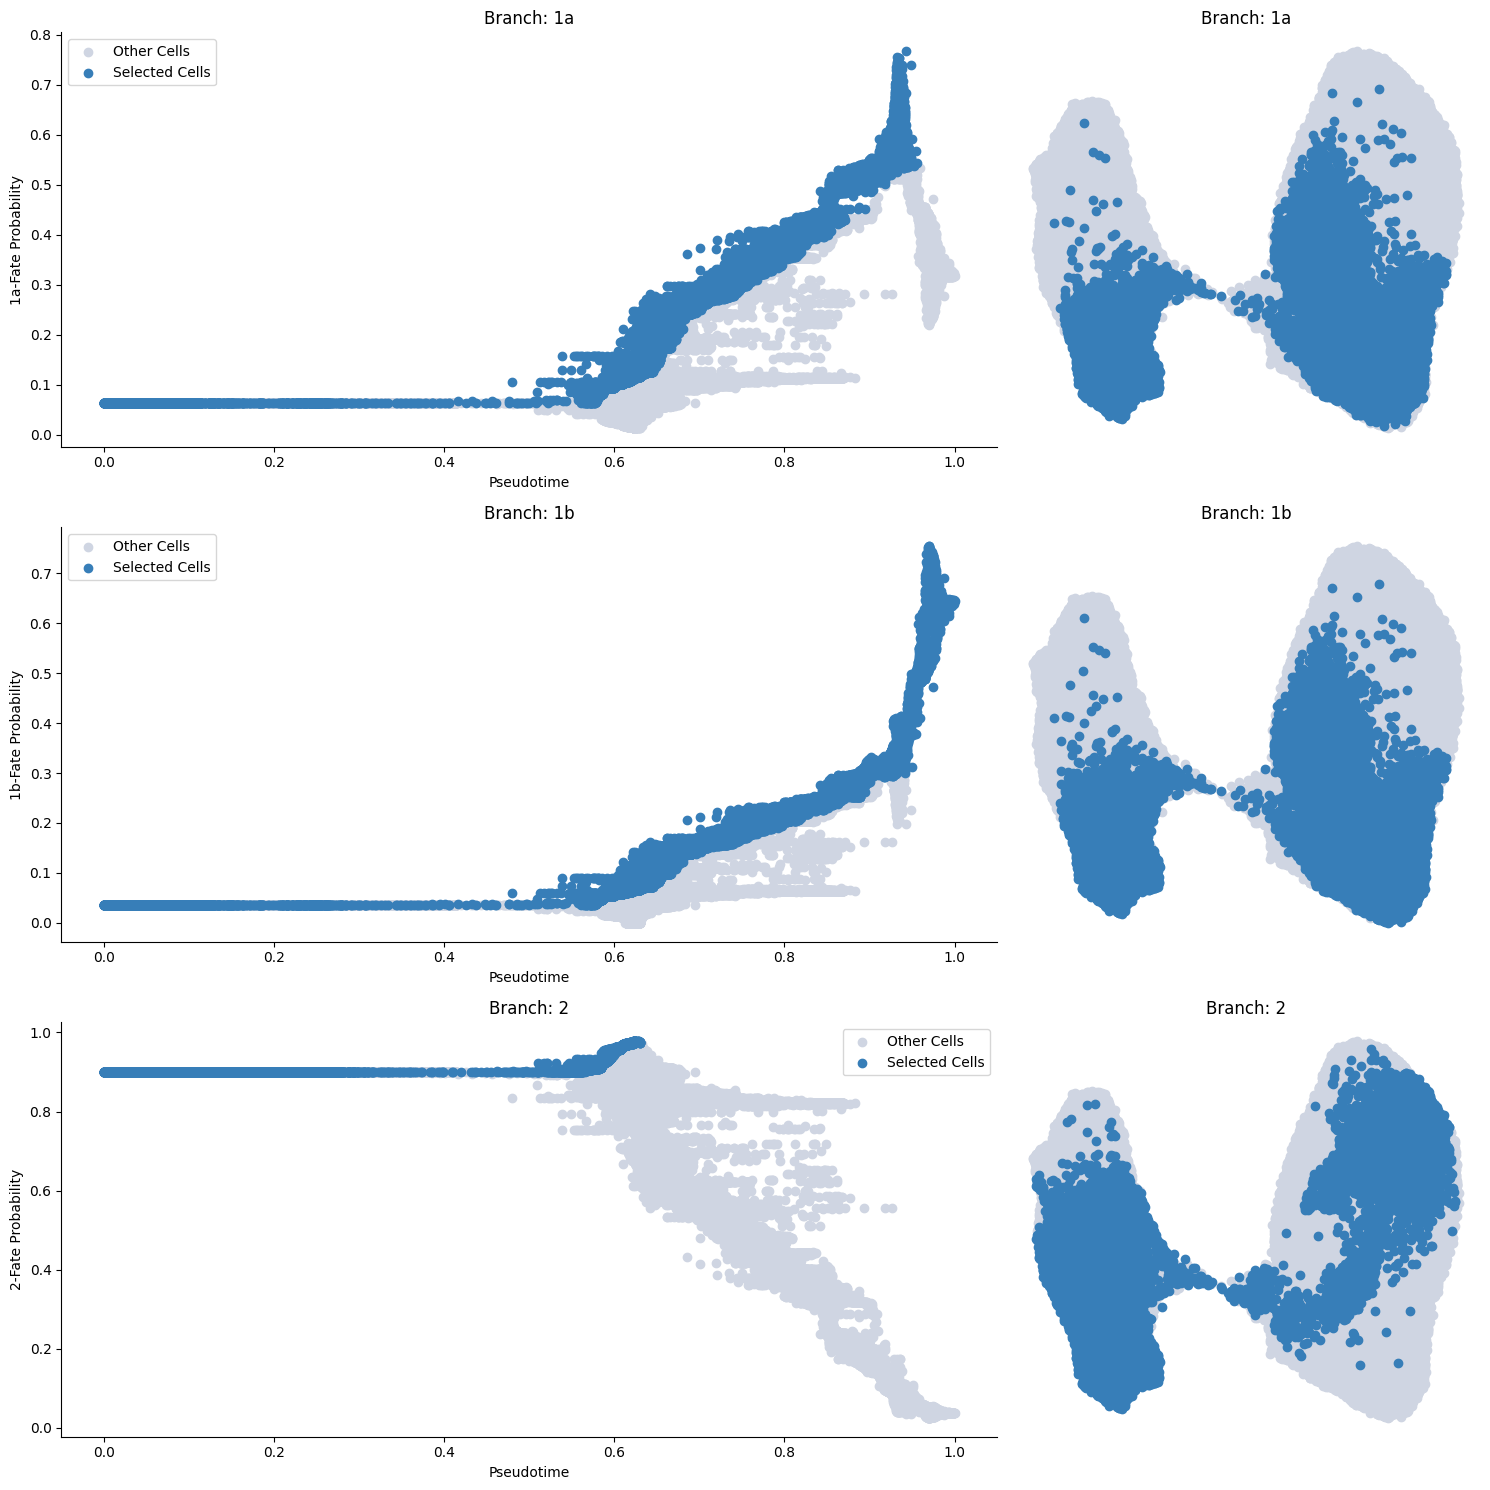

In [27]:
palantir.plot.plot_branch_selection(gene_sub, embedding_basis='X_umap_seurat')

[2025-10-29 11:30:05,694] [INFO    ] Using sparse Gaussian Process since n_landmarks (50) < n_samples (26,650) and rank = 1.0.
[2025-10-29 11:30:05,694] [INFO    ] Using covariance function Matern52(ls=1.2699914377674784).
[2025-10-29 11:30:05,707] [INFO    ] Computing 50 landmarks with k-means clustering (random_state=42).
[2025-10-29 11:30:07,242] [INFO    ] Sigma interpreted as element-wise standard deviation.


<Axes: title={'center': 'Branch: 1a'}>

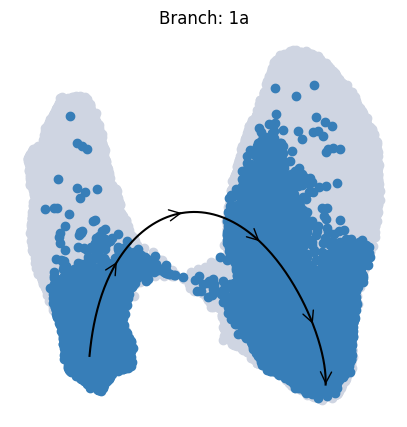

In [28]:
palantir.plot.plot_trajectory(gene_sub,'1a', embedding_basis='X_umap_seurat')

[2025-10-09 15:34:40,590] [INFO    ] Using sparse Gaussian Process since n_landmarks (50) < n_samples (32,314) and rank = 1.0.
[2025-10-09 15:34:40,590] [INFO    ] Using covariance function Matern52(ls=1.2699914377674784).
[2025-10-09 15:34:40,591] [INFO    ] Computing 50 landmarks with k-means clustering (random_state=42).
[2025-10-09 15:34:41,117] [INFO    ] Sigma interpreted as element-wise standard deviation.


<Axes: title={'center': 'Branch: 2'}>

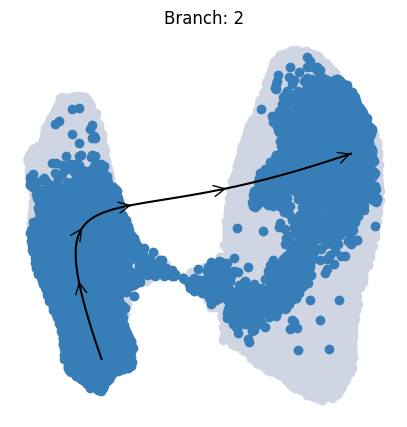

In [374]:
palantir.plot.plot_trajectory(gene_sub,'2', embedding_basis='X_umap_seurat')

[2025-10-09 15:32:25,795] [INFO    ] Using sparse Gaussian Process since n_landmarks (50) < n_samples (26,650) and rank = 1.0.
[2025-10-09 15:32:25,795] [INFO    ] Using covariance function Matern52(ls=1.2699914377674784).
[2025-10-09 15:32:25,796] [INFO    ] Computing 50 landmarks with k-means clustering (random_state=42).
[2025-10-09 15:32:26,004] [INFO    ] Sigma interpreted as element-wise standard deviation.


<Axes: title={'center': 'Branch: 1a'}, xlabel='umap_seurat1', ylabel='umap_seurat2'>

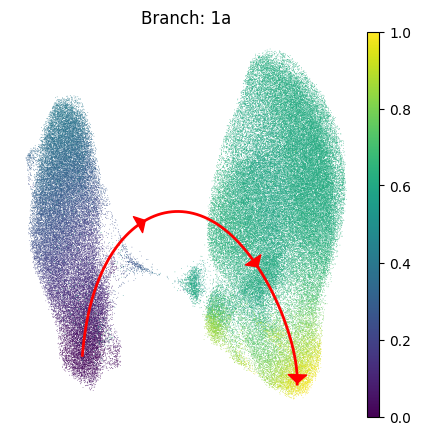

In [373]:
palantir.plot.plot_trajectory(
    gene_sub,
    '1a'
,
    cell_color="palantir_pseudotime",
    n_arrows=3,
    color="red",
    scanpy_kwargs=dict(cmap="viridis"),
    arrowprops=dict(arrowstyle="-|>,head_length=.3, head_width=.33"),
    lw=2, # thickness of the path
    embedding_basis='X_umap_seurat'
)

[2025-10-09 11:11:33,400] [INFO    ] Using sparse Gaussian Process since n_landmarks (50) < n_samples (17,195) and rank = 1.0.
[2025-10-09 11:11:33,400] [INFO    ] Using covariance function Matern52(ls=1.2699914377674784).
[2025-10-09 11:11:33,401] [INFO    ] Computing 50 landmarks with k-means clustering (random_state=42).
[2025-10-09 11:11:33,553] [INFO    ] Sigma interpreted as element-wise standard deviation.


<Axes: title={'center': 'Branch: 2'}, xlabel='umap_seurat1', ylabel='umap_seurat2'>

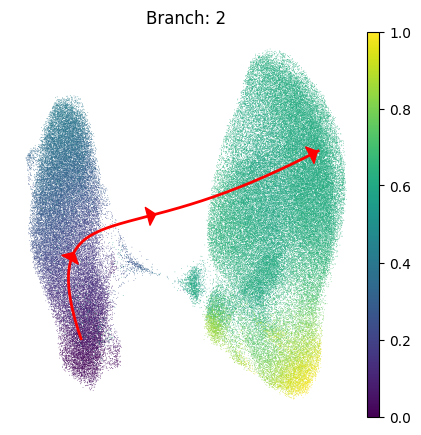

In [79]:
palantir.plot.plot_trajectory(
    gene_sub,
    '2',
    cell_color="palantir_pseudotime",
    n_arrows=3,
    color="red",
    scanpy_kwargs=dict(cmap="viridis"),
    arrowprops=dict(arrowstyle="-|>,head_length=.3, head_width=.33"),
    lw=2, # thickness of the path
    embedding_basis='X_umap_seurat'
)

[2025-07-08 14:37:45,384] [INFO    ] Using sparse Gaussian Process since n_landmarks (50) < n_samples (27,439) and rank = 1.0.
[2025-07-08 14:37:45,384] [INFO    ] Using covariance function Matern52(ls=1.1869239405996659).
[2025-07-08 14:37:45,384] [INFO    ] Computing 50 landmarks with k-means clustering (random_state=42).
[2025-07-08 14:37:45,607] [INFO    ] Sigma interpreted as element-wise standard deviation.


<Axes: title={'center': 'Branch: CM110_TACCAAATCCCGTTAC-1'}, xlabel='umap_seurat1', ylabel='umap_seurat2'>

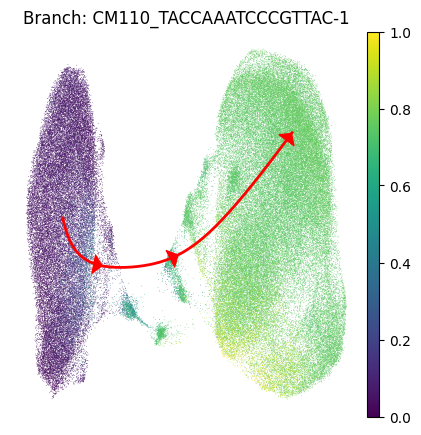

In [161]:
palantir.plot.plot_trajectory(
    adata_subset,
    'CM110_TACCAAATCCCGTTAC-1',
    cell_color="palantir_pseudotime",
    n_arrows=3,
    color="red",
    scanpy_kwargs=dict(cmap="viridis"),
    arrowprops=dict(arrowstyle="-|>,head_length=.3, head_width=.33"),
    lw=2, # thickness of the path
    embedding_basis='X_umap_seurat'
)

In [ ]:
cells = ["TTTATGGAGGAC-5", 'TTTGGTGCAGCT-7', 'TTTGTGTTCGGT-5']
palantir.plot.plot_terminal_state_probs(adata_subset, cells)

In [30]:
gene_trends = palantir.presults.compute_gene_trends(
    gene_sub,
    expression_key="MAGIC_imputed_data"
)

1a
[2025-10-29 11:36:08,513] [INFO    ] Using sparse Gaussian Process since n_landmarks (500) < n_samples (26,650) and rank = 1.0.
[2025-10-29 11:36:08,514] [INFO    ] Using covariance function Matern52(ls=1.0).
[2025-10-29 11:36:09,331] [INFO    ] Sigma interpreted as element-wise standard deviation.
1b
[2025-10-29 11:36:09,513] [INFO    ] Using sparse Gaussian Process since n_landmarks (500) < n_samples (28,993) and rank = 1.0.
[2025-10-29 11:36:09,514] [INFO    ] Using covariance function Matern52(ls=1.0).
[2025-10-29 11:36:09,946] [INFO    ] Sigma interpreted as element-wise standard deviation.
2
[2025-10-29 11:36:10,093] [INFO    ] Using sparse Gaussian Process since n_landmarks (500) < n_samples (32,314) and rank = 1.0.
[2025-10-29 11:36:10,093] [INFO    ] Using covariance function Matern52(ls=1.0).
[2025-10-29 11:36:10,498] [INFO    ] Sigma interpreted as element-wise standard deviation.


In [375]:
gene_sub.write('adata_sub_palantir_10.09.25.h5ad')

In [ ]:
import matplotlib.pyplot as plt
genes = ['SOX2', 'PAX6', 'NES', 'ASCL1','SOX11', 'SOX4','HES5','RSPO2', 'ANGPT1', 'KIT', 'CPAMD8', 'SEMA3D', 'FOS','HSPB8',
         'PRKX','SMOC1','ID3', 'NMB', 'APLNR','ADIRF', 
         'TNC', 'JUNB', 'IGFBP5', 'BAMBI',
                    'GJA1', 'PRTG','B2M','HES1', 'S100A10',
                 'FABP7', 'NOTCH1','NOTCH2', 'MKI67', 'MCM2', 'PCNA',  'FOXO3', 'NEUROG2', 'OLIG1', 'OLIG2',
                 'NEUROD1', 'TOP2A','NR2E1', 'MYT1L', 'CALB1', 'CALB2',
                 'RELN','ST8SIA2','ST8SIA4','DCX', 'STMN2', 'TUBB3', 'PROX1', 'FST', 'BHLHE22', 'POSTN',
                 'RBFOX3', 'SYT1', 'MBP', 'GAD1', 'GAD2', 'SHH',
                 'HHIP', 'BMP2', 'BMP4', 'BMP7','BMPR1A','BMPR1B', 'BMPR2','COL25A1',
                 'NOG', 'GREM1', 'WNT3A', 'WNT5A', 'WNT7A','LRP6','FZD7', 'AXIN2','DVL1','DVL2','CTNNB1', 
                    'MARCKS', 'YAP1', 'HES6', 'ERBB4', 'BHLHE40', 'EGFR', 'FGF1', 'FGF2', 'HEY2', 'WNT3',
                    'DOCK7', 'NAV2', 'REST', 'ANXA2', 'CEBPA', 'LPAR1', 'MAN2A1', 'CHD7','OPRM1','GDF7', 'TRIM32', 'SEMA6C', 'NELL1',
                    'CREB3L1', 'MDGA2', 'CX3CR1', 'CSF1R', 'INPP5D', 'PTPRC']

genes2 = ['GFAP','VIM','NES','SOX2','ASCL1','PAX6','NOTCH2','HES1','HES5',
          'NOTCH1','TUBA1A','PCNA',"TUBB3",'STMN1','NEUROD6','CALB2','RELN','DCX','ST8SIA2','SHH','CHRM3','NELL1','ELMO1','FST',"POSTN",
          "BHLHE22",'STMN2','PROX1',
          "CALB1","RBFOX3",'MYT1L','SYT1'
         ]


genes3 = ['NES','VIM','GFAP','ASCL1','SOX2','PAX6','HES1','NOTCH1',
           'HES5','RELN','NEUROD6','CALB2','STMN1', 'MCM2',
          "TUBB3", 'STMN2','PCNA','NEUROD1','CENPF','NNAT','FEZF2',"CALB1",'RBFOX3','SYT1',
          "BHLHE22",'SEMA6C','PROX1','DCX','FST',"POSTN",
         ]

genes4 = ['NES','VIM','GFAP','ASCL1','SOX2','PAX6','HES1','NOTCH1',
           'HES5','NEUROD6','DCX','RELN','CALB2',
          "TUBB3",'FST','STMN1',"BHLHE22","POSTN",'FEZF2','MCM2','STMN2','NNAT','NEUROD1','PROX1','PCNA','CENPF',"CALB1",
          'SEMA6C','RBFOX3','SYT1',
         ]

fig = palantir.plot.plot_gene_trend_heatmaps(gene_sub, genes3, scaling='z-score',vmin=-1.5, vmax=4,basefigsize=(5,0.2))
fig.savefig("palantir_gene_trends_branch_down.pdf", format="pdf", bbox_inches="tight")
